# Tweets sentiment analysis with RNN

Using tweet text embeddings and RNN following a dense layer

In [236]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
FILE_ID='D-RNN-v1'

In [237]:
df = pd.read_csv('./train_enriched.csv')
X = df['clean_text'].fillna('').to_numpy()
Y = df['target'].to_numpy()

X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.1, shuffle=True)

print(X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape)
X_train[:3]

(6851,) (6851,) (762,) (762,)


array(['episcopal priests on road trip with interracial family shares harrowing story of police harassment via',
       'outdoor siren test 2pm the fgcu siren will be tested at 2pm today another message will be sent when the test is concluded',
       'the mf life is a vocal and lyrical bomb saw her live this summer amazing vocalist rt melanie fiona is so slept on'],
      dtype=object)

In [238]:
print(df['clean_text'].isna().sum())

29


In [239]:
VOCABULARY_SIZE = 10000
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 256
LSTM_HIDDEN_STATES = 16
DENSE_HIDDEN_STATES = 16

In [240]:
[x for x in X_train if 'float' in str(type(x))]

[]

In [241]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCABULARY_SIZE, output_sequence_length=MAX_SEQ_LEN)
encoder.adapt(X_train)

In [242]:
vocabulary = encoder.get_vocabulary()
print('Vocabulary size:', VOCABULARY_SIZE)

Vocabulary size: 10000


In [243]:
example = X_train[11]
encoded = encoder(example)
print('Example:', example)
words = [vocabulary[e] for e in encoded]
decoded = ' '.join(words)
print('Decoded:', decoded)


Example: cruz iran deal leaves american hostages languishing in iran
Decoded: cruz iran deal leaves american hostages languishing in iran                                                                                           


In [244]:
def get_1_RNN_model():    
    return tf.keras.Sequential([
        encoder, 
        tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_HIDDEN_STATES)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(DENSE_HIDDEN_STATES, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model = get_1_RNN_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [245]:
checkpoint_path = f"{FILE_ID}-best_model"  # Path where the model will be saved
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, 
                                                mode='min', save_weights_only=True)

model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev), epochs=3, callbacks=[checkpoint])

Epoch 1/3


2024-05-01 14:00:18.221060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2024-05-01 14:00:19.673405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


215/215 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.7053
Epoch 1: val_loss improved from inf to 0.46806, saving model to D-RNN-v1-best_model
215/215 [==============================] - 23s 89ms/step - loss: 0.5791 - accuracy: 0.7053 - val_loss: 0.4681 - val_accuracy: 0.7861
Epoch 2/3
215/215 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8558
Epoch 2: val_loss did not improve from 0.46806
215/215 [==============================] - 17s 80ms/step - loss: 0.3719 - accuracy: 0.8558 - val_loss: 0.4743 - val_accuracy: 0.7992
Epoch 3/3
215/215 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9034
Epoch 3: val_loss did not improve from 0.46806
215/215 [==============================] - 17s 78ms/step - loss: 0.2534 - accuracy: 0.9034 - val_loss: 0.5874 - val_accuracy: 0.7992


In [246]:
def get_2_RNN_model():    
    return tf.keras.Sequential([
        encoder, 
        tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_HIDDEN_STATES, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_HIDDEN_STATES//2)),
        tf.keras.layers.Dense(DENSE_HIDDEN_STATES, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# model2 = get_2_RNN_model()
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
# model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [247]:
# model2.fit(X_train, Y_train, batch_size=128, validation_data=(X_dev, Y_dev), epochs=4)

In [248]:
model.load_weights(checkpoint_path)
Y_dev_pred = model.predict(X_dev)

24/24 [==============================] - 3s 10ms/step


In [249]:
Y_dev_pred = (Y_dev_pred > .5).astype(np.int8)


In [250]:
X_dev[0]

'ty for the follow go to brutally abuseddesolateamplost her lovely mum diesis it murder'

In [251]:
result = pd.DataFrame(X_dev)
result['y'] = Y_dev
result['yp'] = Y_dev_pred

f_encode = lambda it: encoder(it)
f_embedd = lambda it: ' '.join([vocabulary[e] for e in it])

encoded = f_encode(X_dev)
decoded = np.apply_along_axis(f_embedd, axis=1, arr=encoded)
print(decoded[1])
print(X_dev[1])

result['decoded'] = decoded
result

any new games coming soon                                                                                               
any new games coming soon


,0,y,yp,decoded
0,ty for the follow go to brutally abuseddesolateamplost her lovely mum diesis it murder,1,0,ty for the follow go to brutally [UNK] her lovely mum [UNK] it murder
1,any new games coming soon,0,0,any new games coming soon
2,let me report it to u people instead mrobama just declares cnmi federal disaster area post typhoon soudelor u guys 2slow2report,1,1,let me report it to u people instead [UNK] just declares [UNK] federal disaster area post typhoon soudelor u guys [UNK]
3,do anything to fix that of the few people he had every trusted in his life charles was one of the casualties,1,0,do anything to fix that of the few people he had every [UNK] in his life charles was one of the casualties
4,wftv eyewitness news tn school psychologist arrested in florida on child porn charges,0,1,wftv eyewitness news [UNK] school [UNK] arrested in florida on child porn charges
...,...,...,...,...
757,today will be another dualcom with if you enjoyed yesterdays check out todays at pm easter,0,0,today will be another [UNK] with if you enjoyed yesterdays check out todays at pm [UNK]
758,learning from the legacy of a catastrophic eruption the new yorker,1,1,learning from the legacy of a catastrophic eruption the new yorker
759,i remember the heat wave the year i went bruh and they dont have ac,0,0,i remember the heat wave the year i went bruh and they dont have ac
760,smh photographer wolter peeters was on the front line with nsw rural fire service crews la,1,1,smh photographer [UNK] [UNK] was on the front line with [UNK] [UNK] fire service crews la


In [252]:
pd.set_option('display.max_colwidth', None)
result.query('y != yp').sample(n=10)

,0,y,yp,decoded
666,my back is so sunburned,1,0,my back is so [UNK]
482,survived because of magic she is searching the wood for survivors outside of london,1,0,survived because of magic she is searching the wood for survivors outside of london
119,hes already done it by negotiating with the state of terrorism in the world what was his hurry in trying to get a deal,1,0,hes already done it by [UNK] with the state of terrorism in the world what was his hurry in trying to get a deal
296,radiation emergency preparedness starts with knowing to get inside stay inside and stay tuned via,1,0,radiation emergency preparedness starts with knowing to get inside stay inside and stay tuned via
379,mercury cyclone gt hood moulding very nice core cobra jet 429cj gt,0,1,mercury cyclone gt [UNK] moulding very nice [UNK] cobra jet [UNK] gt
165,i never knew about the relationship btwn kansas city hyatt bridge collapse amp aias cote via,1,0,i never knew about the relationship btwn [UNK] city [UNK] bridge collapse amp [UNK] [UNK] via
519,big top burning the true story of an arsonist a missing girl,1,0,big top burning the true story of an arsonist a missing girl
258,like a beautiful ass tragedy lol,1,0,like a beautiful ass tragedy lol
447,ted cruz bashes obama comparison gop to iranians shouting death to america tcot,1,0,ted cruz [UNK] obama comparison gop to [UNK] shouting death to america tcot
580,manuel hoping for an early buffalo snowstorm so his accuracy improves,1,0,[UNK] hoping for an early buffalo snowstorm so his [UNK] [UNK]


Accuracy: 0.7860892388451444
Precision: 0.8088001097251537
Recall: 0.7797365950632282
F1 Score: 0.7791575320179438


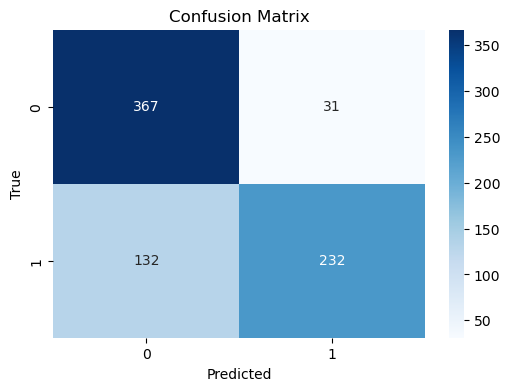

In [253]:
# Compute the confusion matrix
cm = confusion_matrix(Y_dev, Y_dev_pred)

# Compute other metrics
accuracy = accuracy_score(Y_dev, Y_dev_pred)
precision = precision_score(Y_dev, Y_dev_pred, average='macro')
recall = recall_score(Y_dev, Y_dev_pred, average='macro')
f1 = f1_score(Y_dev, Y_dev_pred, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [254]:
def generate_submission(model):
    df_test = pd.read_csv('./test_enriched.csv', index_col='id')
    df_test.fillna({'clean_text': '', 'keyword': '', 'location': '', 'country': '', 'state': '', 'city': '', 'url_domains': ''}, inplace=True)
    X_test = df_test['clean_text'].to_numpy()

    Y_test_predict = model(X_test)
    Y_test_predict = tf.cast(Y_test_predict > .5, tf.int32)

    df_example = pd.read_csv('./sample_submission.csv')
    df_example['target'] = Y_test_predict

    df_example.to_csv(f'./{FILE_ID}-submission.csv', index=False)


In [255]:
# generate_submission(model)